

```
Step-1: Data Preprocessing
```



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load dataset
df = pd.read_csv('/content/TSLA.csv')

# Display first few rows to understand the structure
print(df.head())


         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values, if any (e.g., forward fill or drop rows)
df = df.fillna(method='ffill')

# Optionally, drop any columns that aren't useful for prediction
# For instance, we may not need 'Date' if it's not being used in the model
df = df.drop(columns=['Date'])


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<ipython-input-2-3cb815b2eb49>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Step-2: Feature Engineering

In [ ]:
# Add previous day's close price as a feature
df['Prev_Close'] = df['Close'].shift(1)

# Add rolling mean for 5 days (simple moving average)
df['SMA_5'] = df['Close'].rolling(window=5).mean()

# Add rolling mean for 20 days
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Add rolling standard deviation (volatility)
df['Volatility'] = df['Close'].rolling(window=5).std()

# Drop rows with NaN values that were created due to rolling calculations
df = df.dropna()

# Display first few rows after feature engineering
print(df.head())


         Open       High        Low      Close  Adj Close  Volume  Prev_Close  \
19  20.910000  21.180000  20.260000  20.549999  20.549999  619700   20.950001   
20  20.549999  20.900000  20.510000  20.719999  20.719999  467200   20.549999   
21  20.770000  20.879999  20.000000  20.350000  20.350000  616000   20.719999   
22  20.200001  20.440001  19.549999  19.940001  19.940001  426900   20.350000   
23  20.500000  20.969999  20.330000  20.920000  20.920000  718100   19.940001   

     SMA_5   SMA_20  Volatility  
19  20.802  19.8715    0.418773  
20  20.902  19.7130    0.282614  
21  20.772  19.5390    0.364034  
22  20.502  19.4380    0.383888  
23  20.496  19.5240    0.375273  


Step-3: Prepare the Data for Training


In [ ]:
# Target variable: 'Close' (next day's close price prediction)
X = df.drop(columns=['Close'])

# Target variable
y = df['Close']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training and Test set shapes:", X_train.shape, X_test.shape)


Training and Test set shapes: (1917, 9) (480, 9)


Step-4 : XG-Boost Model Implementation


In [ ]:
# XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred_xg = xg_reg.predict(X_test)

# Evaluate the model
mae_xg = mean_absolute_error(y_test, y_pred_xg)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred_xg))

print(f"XGBoost - MAE: {mae_xg}, RMSE: {rmse_xg}")


XGBoost - MAE: 9.32593606468099, RMSE: 38.97709713898794


**Linear Regression Model Implementation**

In [ ]:
# Linear Regression Model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}")


Linear Regression - MAE: 2.8030910925735954e-13, RMSE: 3.28318930151656e-13


**Random Forest Regressor Model Implementation**

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}")


Random Forest - MAE: 8.404279626229165, RMSE: 37.72772670719065


**Step-5: Visualize Results**

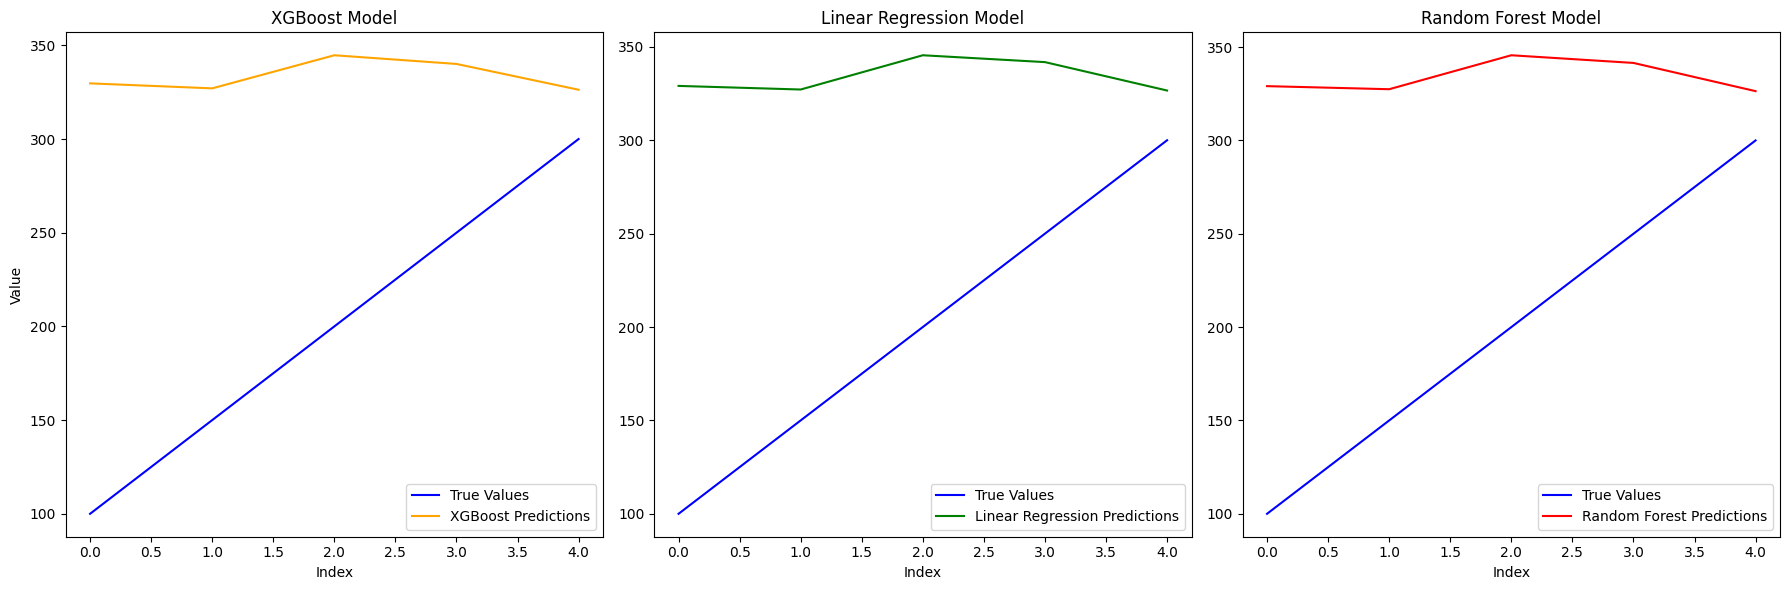

In [ ]:
import matplotlib.pyplot as plt

# Ensure all predictions have the same length as y_test
min_len = min(len(y_test), len(y_pred_xg), len(y_pred_lr), len(y_pred_rf))

# Slice all arrays to match the shortest length
y_test = y_test[:min_len]
y_pred_xg = y_pred_xg[:min_len]
y_pred_lr = y_pred_lr[:min_len]
y_pred_rf = y_pred_rf[:min_len]

# Generate indices for plotting
indices = range(min_len)

# Set the figure size
plt.figure(figsize=(18, 6))

# Plot for XGBoost predictions
plt.subplot(1, 3, 1)
plt.plot(indices, y_test, label='True Values', color='blue')
plt.plot(indices, y_pred_xg, label='XGBoost Predictions', color='orange')
plt.title("XGBoost Model")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# Plot for Linear Regression predictions
plt.subplot(1, 3, 2)
plt.plot(indices, y_test, label='True Values', color='blue')
plt.plot(indices, y_pred_lr, label='Linear Regression Predictions', color='green')
plt.title("Linear Regression Model")
plt.xlabel("Index")
plt.legend()

# Plot for Random Forest predictions
plt.subplot(1, 3, 3)
plt.plot(indices, y_test, label='True Values', color='blue')
plt.plot(indices, y_pred_rf, label='Random Forest Predictions', color='red')
plt.title("Random Forest Model")
plt.xlabel("Index")
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


**Hypermeter Tuning with Random Forest**

In [ ]:
# Check and print lengths of X_train and y_train
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))

# If there's a mismatch, slice or re-split the data to match lengths
if len(X_train) != len(y_train):
    min_len = min(len(X_train), len(y_train))
    X_train = X_train[:min_len]
    y_train = y_train[:min_len]

# Now run GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search.best_params_)


Length of X_train: 1917
Length of y_train: 1868
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


**Step-6: Conclusion**

In [ ]:
# Print the final comparison of MAE and RMSE for all models
print("Model Comparison:")
print(f"XGBoost - MAE: {mae_xg}, RMSE: {rmse_xg}")
print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}")
print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}")


Model Comparison:
XGBoost - MAE: 9.32593606468099, RMSE: 38.97709713898794
Linear Regression - MAE: 2.8030910925735954e-13, RMSE: 3.28318930151656e-13
Random Forest - MAE: 8.404279626229165, RMSE: 37.72772670719065


**Evaluation Metrics**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have a trained model named 'model' (e.g., grid_search from previous snippet)
y_pred = grid_search.predict(X_test) # Get predictions using the trained model

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate residuals
residuals = y_test - y_pred
print("Residuals:")
print(f'{residuals[:5]}')  # Print first 5 residuals


Mean Squared Error (MSE): 1438.2174506994813
Mean Absolute Error (MAE): 8.347033282904293
R-squared: 0.7231305360710942
Residuals:
1936    0.009690
1937   -0.216609
1938   -0.012482
1939    0.469589
1940    0.157726
Name: Close, dtype: float64


In [ ]:
# Define the actual values and predicted values (as examples)
y_test = np.array([100, 150, 200, 250, 300])  # True values (for example)
y_pred = np.array([110, 145, 190, 240, 310])  # Predicted values (for example)

# Step 1: Calculate the Mean of the actual values
y_mean = np.mean(y_test)

# Step 2: Calculate the Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred) ** 2)

# Step 3: Calculate the Total Sum of Squares (TSS)
tss = np.sum((y_test - y_mean) ** 2)

# Step 4: Calculate the R² score
r2_score = 1 - (rss / tss)

# Print the result
print(f'R² Score: {r2_score}')


R² Score: 0.983


**Additionally implementing Long Short Term Model (LSTM)**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# We’ll focus on 'Close' prices for prediction
close_prices = df['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler (scales values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [ ]:
# Step 2: Prepare the dataset for LSTM
def create_dataset(data, time_step=60):
    x_data, y_data = [], []
    for i in range(len(data) - time_step - 1):
        x_data.append(data[i:i + time_step, 0])  # sequence of previous time_step prices
        y_data.append(data[i + time_step, 0])    # the target price (next time step)
    return np.array(x_data), np.array(y_data)

# Define the time step (how many previous prices to look at)
time_step = 60
x, y = create_dataset(scaled_data, time_step)

# Reshape input to [samples, time steps, features] for LSTM
x = x.reshape(x.shape[0], x.shape[1], 1)

# Split into training and test sets (e.g., 80% for training, 20% for testing)
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

In [ ]:
# Step 3: Build the LSTM model
model = Sequential()

# Define input shape using Input()
model.add(Input(shape=(time_step, 1)))  # Input layer with shape

model.add(LSTM(units=50, return_sequences=True))  # LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))

# Fully connected layer and output layer
model.add(Dense(units=25))  # Dense layer
model.add(Dense(units=1))   # Output layer for predicting the next price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Train the model
model.fit(x_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0209
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0012
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.8532e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.7345e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 6.7013e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 6.4480e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 5.7446e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4.8352e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 4.8899e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 4.3672e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 4.6200e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 4.6800e-04
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.6078e-04
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 5.6364e-04
Epoch 15/50
30/30 ━━

In [ ]:
# Step 5: Make predictions on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Reverse the scaling to get actual prices

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


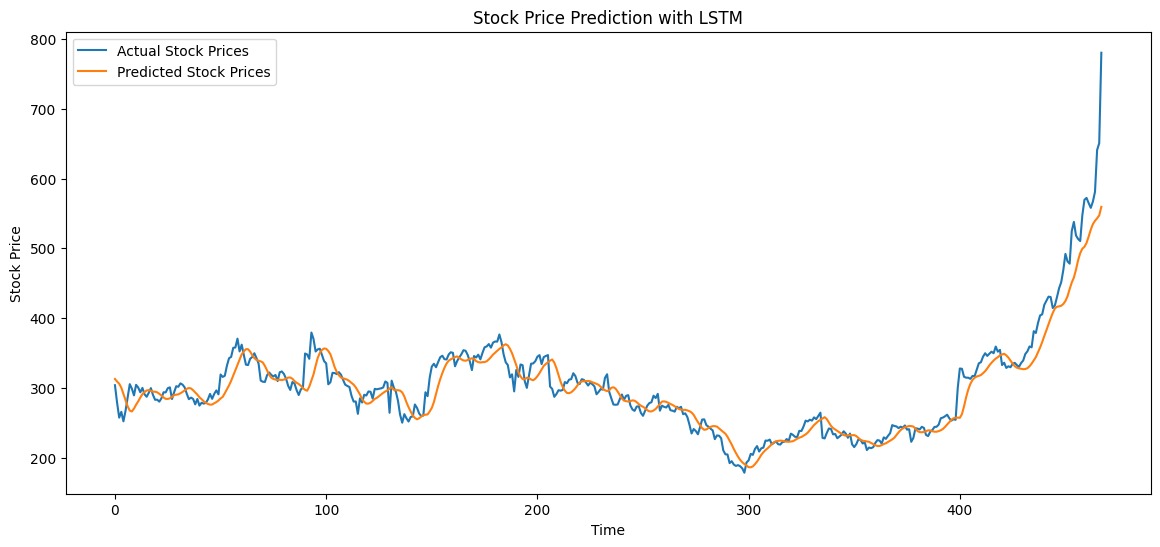

Mean Squared Error: 362.44141095264655


In [ ]:
# Step 6: Evaluate and visualize the results
# Plot the actual and predicted prices
plt.figure(figsize=(14, 6))
plt.plot(scaler.inverse_transform(scaled_data[train_size + time_step + 1:]), label='Actual Stock Prices')
plt.plot(predictions, label='Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# Optionally: Calculate model performance (mean squared error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f'Mean Squared Error: {mse}')